In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
df1 = pd.read_csv("reliance dataset_1.csv")
df2 = pd.read_csv("reliance dataset_2.csv")
df3 = pd.read_csv("reliance dataset_3.csv")

df4 = pd.read_csv("reliance dataset_4.csv")
df5 = pd.read_csv("reliance dataset_5.csv")
df6 = pd.read_csv("reliance dataset_6.csv")

df_underlying = pd.read_csv("reliance_underlying_2023.csv")

In [4]:
def data_transf(df):
 df_transformed = df[(df['OPEN PRICE '] != '-') & (df['HIGH PRICE '] != '-') & (df['LOW PRICE '] != '-')]
 
 df_transformed['EXPIRY DATE '] = pd.to_datetime(df_transformed['EXPIRY DATE '])
 df_transformed['DATE '] = pd.to_datetime(df_transformed['DATE '])
 df_transformed['TIME TO EXPIRY (YEARS) '] = ((df_transformed['EXPIRY DATE '] - df_transformed['DATE '])/np.timedelta64(1, 'D'))/365
 
 df_transformed[["STRIKE PRICE ","OPEN PRICE ","HIGH PRICE ","LOW PRICE ","CLOSE PRICE ","LAST PRICE ","SETTLE PRICE ","Volume ","VALUE ","PREMIUM VALUE "]] = df_transformed[["STRIKE PRICE ","OPEN PRICE ","HIGH PRICE ","LOW PRICE ","CLOSE PRICE ","LAST PRICE ","SETTLE PRICE ","Volume ","VALUE ","PREMIUM VALUE "]].applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
 return df_transformed

def data_transf_underlying(df_underlying_asset):
 df_underlying_transformed = df_underlying_asset[['Date ', 'close ']]
 df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
 df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
 return df_underlying_transformed

def data_merge(df, df_underlying_asset):
 df_underlying_transformed = data_transf_underlying(df_underlying_asset)
 df_merged = pd.merge(df, df_underlying_transformed, left_on = 'DATE ', right_on = 'Date ')
 return df_merged

def black_scholes_function(K, S, t, r, sigma, option_type):
    # r and sigma as fraction annual rates (eg 0.2 for 20% annual rate) 
    # K, S in currency units
    # t in years
    d1 = (np.log(S/K) + (r + (sigma**2)/2)*t)/(sigma*(np.sqrt(t)))
    d2 = d1 - (sigma*(np.sqrt(t)))

    if(option_type == 'call'):
     N1 = stats.norm.cdf(d1, loc=0, scale=1)
     N2 = stats.norm.cdf(d2, loc=0, scale=1)
     price = N1*S - N2*K*(np.exp(-r*t))
    else:
     N1 = stats.norm.cdf(-d1, loc=0, scale=1)
     N2 = stats.norm.cdf(-d2, loc=0, scale=1)
     price = N2*K*(np.exp(-r*t)) - N1*S

    return price

def black_scholes_pred(df, r, sigma, option_type):
    # input r and sigma as fraction annual rates (eg 0.2 for 20% annual rate) 
    prices = black_scholes_function(df['STRIKE PRICE '], df['close '], df['TIME TO EXPIRY (YEARS) '], r, sigma, option_type)
    final_data = df = pd.DataFrame({
     'Date ': df['DATE '],
     'predicted_price': prices
     })
    return final_data
    
def volatility_calculator(df_underlying_asset):
    #Gives annual volatility as a fraction of 100
    df_underlying_transformed = data_transf_underlying(df_underlying_asset)
    log_returns = np.zeros((df_underlying_transformed.shape[0] - 1, 1))

    for i in range(log_returns.shape[0]):
     log_returns[i] = np.log((df_underlying_transformed['close '][i+1])/(df_underlying_transformed['close '][i]))

    daily_volatility = np.std(log_returns)

    sigma = daily_volatility * np.sqrt(log_returns.shape[0])
    return sigma

def binomial_tree_option(S, K, T, r, sigma, N, option_type, american=False):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    asset_prices = np.zeros(N+1)
    asset_prices[0] = S * d**N
    for i in range(1, N+1):
        asset_prices[i] = asset_prices[i-1] * u / d
    
    option_values = np.zeros(N+1)
    if option_type == "call":
        option_values = np.maximum(0, asset_prices - K)
    else:
        option_values = np.maximum(0, K - asset_prices)
    
    for t in range(N-1, -1, -1):
        for i in range(t+1):
            option_values[i] = np.exp(-r * dt) * (p * option_values[i+1] + (1 - p) * option_values[i])
            if american:
                if option_type == "call":
                    option_values[i] = max(option_values[i], asset_prices[i] - K)
                else:
                    option_values[i] = max(option_values[i], K - asset_prices[i])
        asset_prices = asset_prices[:-1] * d / u
    
    return option_values[0]

def binomial_tree_array(df, r, sigma, N, option_type):
    predicted_prices = np.zeros((df.shape[0]))
    
    for i in range(df.shape[0]):
        predicted_prices[i] = binomial_tree_option(df['close '][i], df['STRIKE PRICE '][i], df['TIME TO EXPIRY (YEARS) '][i], r, sigma, N, option_type)
    
    final_answer = pd.DataFrame({
     'Date ': df['DATE '],
     'predicted_price': predicted_prices
     })
    return final_answer

In [5]:
df1 = data_transf(df1)
df1 = data_merge(df1, df_underlying)

df2 = data_transf(df2)
df2 = data_merge(df2, df_underlying)

df3 = data_transf(df3)
df3 = data_merge(df3, df_underlying)

df4 = data_transf(df4)
df4 = data_merge(df4, df_underlying)

df5 = data_transf(df5)
df5 = data_merge(df5, df_underlying)

df6 = data_transf(df6)
df6 = data_merge(df6, df_underlying)


C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['EXPIRY DATE '] = pd.to_datetime(df_transformed['EXPIRY DATE '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['DATE '] = pd.to_datetime(df_transformed['DATE '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [6]:
N = 100

In [32]:
df1_result_bn = binomial_tree_array(df1, 0.07, volatility_calculator(df_underlying), N, 'call')
df1_result_bn['actual_price'] = df1['CLOSE PRICE ']
df1_result_bn = df1_result_bn.dropna()
df1_result_bs = black_scholes_pred(df1, 0.07, volatility_calculator(df_underlying), 'call')
df1_result_bs['actual_price'] = df1['CLOSE PRICE ']


df2_result_bn = binomial_tree_array(df2, 0.07, volatility_calculator(df_underlying), N, 'call')
df2_result_bn['actual_price'] = df2['CLOSE PRICE ']
df2_result_bn = df2_result_bn.dropna()
df2_result_bs = black_scholes_pred(df2, 0.07, volatility_calculator(df_underlying), 'call')
df2_result_bs['actual_price'] = df2['CLOSE PRICE ']


df3_result_bn = binomial_tree_array(df3, 0.07, volatility_calculator(df_underlying), N, 'call')
df3_result_bn['actual_price'] = df3['CLOSE PRICE ']
df3_result_bn = df3_result_bn.dropna()
df3_result_bs = black_scholes_pred(df3, 0.07, volatility_calculator(df_underlying), 'call')
df3_result_bs['actual_price'] = df3['CLOSE PRICE ']


df4_result_bn_put = binomial_tree_array(df4, 0.07, volatility_calculator(df_underlying), N, 'put')
df4_result_bn_put['actual_price'] = df4['CLOSE PRICE ']
df4_result_bn_put = df4_result_bn_put.dropna()
df4_result_bs_put = black_scholes_pred(df4, 0.07, volatility_calculator(df_underlying), 'put')
df4_result_bs_put['actual_price'] = df4['CLOSE PRICE ']


df5_result_bn_put = binomial_tree_array(df5, 0.07, volatility_calculator(df_underlying), N, 'put')
df5_result_bn_put['actual_price'] = df5['CLOSE PRICE ']
df5_result_bn_put = df5_result_bn_put.dropna()
df5_result_bs_put = black_scholes_pred(df5, 0.07, volatility_calculator(df_underlying), 'put')
df5_result_bs_put['actual_price'] = df5['CLOSE PRICE ']


df6_result_bn_put = binomial_tree_array(df6, 0.07, volatility_calculator(df_underlying), N, 'put')
df6_result_bn_put['actual_price'] = df6['CLOSE PRICE ']
df6_result_bn_put = df6_result_bn_put.dropna()
df6_result_bs_put = black_scholes_pred(df6, 0.07, volatility_calculator(df_underlying), 'put')
df6_result_bs_put['actual_price'] = df6['CLOSE PRICE ']

C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:66: RuntimeWarning: invalid value encountered in scalar divide
  p = (np.exp(r * dt) - d) / (u - d)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:13: SettingWithCopyWarning: 
A value is tryin

Text(0.5, 1.0, 'Dataset 6 (K = 2600) Binomial Model with step size = 100 (PUT OPTIONS)| MSE = 44.331302216677905')

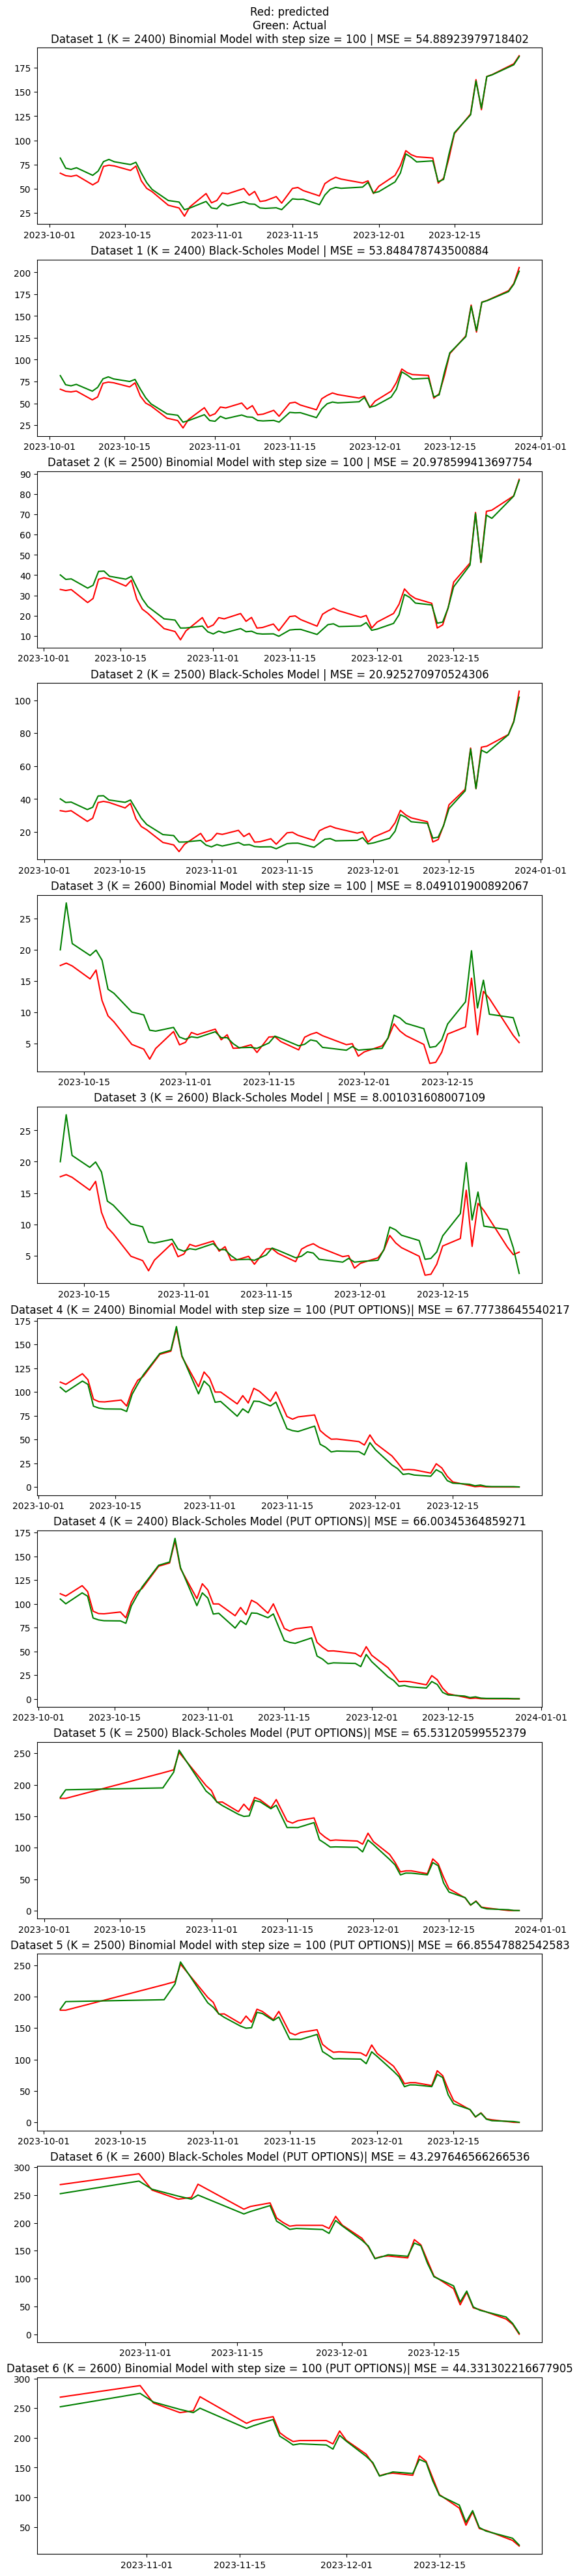

In [33]:
plt.figure(figsize = (10, 50))

plt.subplot(12,1,1)
plt.plot(df1_result_bn['Date '], df1_result_bn['predicted_price'], color = 'red')
plt.plot(df1_result_bn['Date '], df1_result_bn['actual_price'], color = 'green')
plt.title(f'Red: predicted\nGreen: Actual\nDataset 1 (K = 2400) Binomial Model with step size = {N} | MSE = {np.mean((df1_result_bn['predicted_price'] - df1_result_bn['actual_price']) ** 2)}')

plt.subplot(12,1,2)
plt.plot(df1_result_bs['Date '], df1_result_bs['predicted_price'], color = 'red')
plt.plot(df1_result_bs['Date '], df1_result_bs['actual_price'], color = 'green')
plt.title(f'Dataset 1 (K = 2400) Black-Scholes Model | MSE = {np.mean((df1_result_bs['predicted_price'] - df1_result_bs['actual_price']) ** 2)}')



plt.subplot(12,1,3)
plt.plot(df2_result_bn['Date '], df2_result_bn['predicted_price'], color = 'red')
plt.plot(df2_result_bn['Date '], df2_result_bn['actual_price'], color = 'green')
plt.title(f'Dataset 2 (K = 2500) Binomial Model with step size = {N} | MSE = {np.mean((df2_result_bn['predicted_price'] - df2_result_bn['actual_price']) ** 2)}')

plt.subplot(12,1,4)
plt.plot(df2_result_bs['Date '], df2_result_bs['predicted_price'], color = 'red')
plt.plot(df2_result_bs['Date '], df2_result_bs['actual_price'], color = 'green')
plt.title(f'Dataset 2 (K = 2500) Black-Scholes Model | MSE = {np.mean((df2_result_bs['predicted_price'] - df2_result_bs['actual_price']) ** 2)}')



plt.subplot(12,1,5)
plt.plot(df3_result_bn['Date '], df3_result_bn['predicted_price'], color = 'red')
plt.plot(df3_result_bn['Date '], df3_result_bn['actual_price'], color = 'green')
plt.title(f'Dataset 3 (K = 2600) Binomial Model with step size = {N} | MSE = {np.mean((df3_result_bn['predicted_price'] - df3_result_bn['actual_price']) ** 2)}')

plt.subplot(12,1,6)
plt.plot(df3_result_bs['Date '], df3_result_bs['predicted_price'], color = 'red')
plt.plot(df3_result_bs['Date '], df3_result_bs['actual_price'], color = 'green')
plt.title(f'Dataset 3 (K = 2600) Black-Scholes Model | MSE = {np.mean((df3_result_bs['predicted_price'] - df3_result_bs['actual_price']) ** 2)}')


plt.subplot(12,1,7)
plt.plot(df4_result_bn_put['Date '], df4_result_bn_put['predicted_price'], color = 'red')
plt.plot(df4_result_bn_put['Date '], df4_result_bn_put['actual_price'], color = 'green')
plt.title(f'Dataset 4 (K = 2400) Binomial Model with step size = {N} (PUT OPTIONS)| MSE = {np.mean((df4_result_bn_put['predicted_price'] - df4_result_bn_put['actual_price']) ** 2)}')

plt.subplot(12,1,8)
plt.plot(df4_result_bs_put['Date '], df4_result_bs_put['predicted_price'], color = 'red')
plt.plot(df4_result_bs_put['Date '], df4_result_bs_put['actual_price'], color = 'green')
plt.title(f'Dataset 4 (K = 2400) Black-Scholes Model (PUT OPTIONS)| MSE = {np.mean((df4_result_bs_put['predicted_price'] - df4_result_bs_put['actual_price']) ** 2)}')


plt.subplot(12,1,9)
plt.plot(df5_result_bs_put['Date '], df5_result_bs_put['predicted_price'], color = 'red')
plt.plot(df5_result_bs_put['Date '], df5_result_bs_put['actual_price'], color = 'green')
plt.title(f'Dataset 5 (K = 2500) Black-Scholes Model (PUT OPTIONS)| MSE = {np.mean((df5_result_bs_put['predicted_price'] - df5_result_bs_put['actual_price']) ** 2)}')

plt.subplot(12,1,10)
plt.plot(df5_result_bn_put['Date '], df5_result_bn_put['predicted_price'], color = 'red')
plt.plot(df5_result_bn_put['Date '], df5_result_bn_put['actual_price'], color = 'green')
plt.title(f'Dataset 5 (K = 2500) Binomial Model with step size = {N} (PUT OPTIONS)| MSE = {np.mean((df5_result_bn_put['predicted_price'] - df5_result_bn_put['actual_price']) ** 2)}')


plt.subplot(12,1,11)
plt.plot(df6_result_bs_put['Date '], df6_result_bs_put['predicted_price'], color = 'red')
plt.plot(df6_result_bs_put['Date '], df6_result_bs_put['actual_price'], color = 'green')
plt.title(f'Dataset 6 (K = 2600) Black-Scholes Model (PUT OPTIONS)| MSE = {np.mean((df6_result_bs_put['predicted_price'] - df6_result_bs_put['actual_price']) ** 2)}')

plt.subplot(12,1,12)
plt.plot(df6_result_bn_put['Date '], df6_result_bn_put['predicted_price'], color = 'red')
plt.plot(df6_result_bn_put['Date '], df6_result_bn_put['actual_price'], color = 'green')
plt.title(f'Dataset 6 (K = 2600) Binomial Model with step size = {N} (PUT OPTIONS)| MSE = {np.mean((df6_result_bn_put['predicted_price'] - df6_result_bn_put['actual_price']) ** 2)}')


Plotting MSE against number of steps for binomial model  

In [34]:
def cosine_similarity(arr1, arr2):
    dot_pr = np.dot(arr1, np.transpose(arr2))

    mag_arr1 = np.sqrt(np.sum(arr1**2))
    mag_arr2 = np.sqrt(np.sum(arr2**2))
    
    return dot_pr/(mag_arr1*mag_arr2)

In [35]:
n_iter = 300

In [36]:
MSE = np.zeros((n_iter + 1))
CSim = np.zeros((n_iter + 1))
for i in range(1, n_iter + 1):
  df1_result_bn_test = binomial_tree_array(df1, 0.07, volatility_calculator(df_underlying), i, 'call')
  df1_result_bn_test['actual_price'] = df1['CLOSE PRICE ']
  df1_result_bn_test = df1_result_bn_test.dropna()

  MSE[i] = np.mean((df1_result_bn_test['predicted_price'] - df1_result_bn_test['actual_price']) ** 2)
  CSim[i] = cosine_similarity(df1_result_bn_test['predicted_price'], df1_result_bn_test['actual_price'])
    

C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:66: RuntimeWarning: invalid value encountered in scalar divide
  p = (np.exp(r * dt) - d) / (u - d)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18252\3226753945.py:13: SettingWithCopyWarning: 
A value is tryin

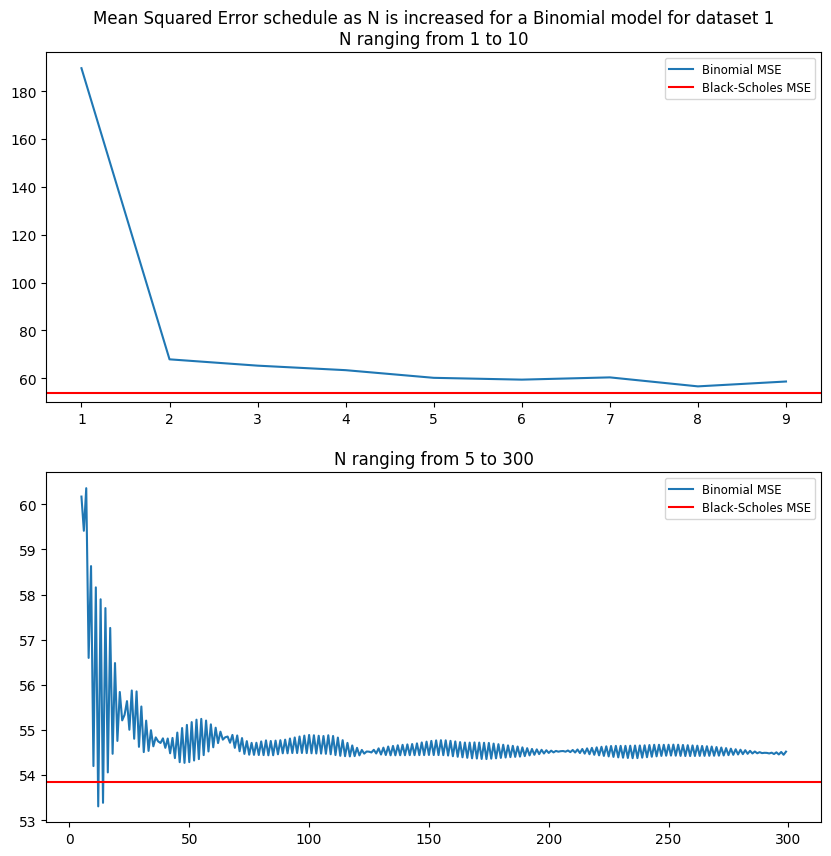

In [13]:
a = 1
b = 10
c = 5
d = 300

plt.figure(figsize = (10,10))

plt.subplot(2, 1, 1)
plt.plot(np.arange(a, b), MSE[a:b], label='Binomial MSE')
plt.title(f'Mean Squared Error schedule as N is increased for a Binomial model for dataset 1\nN ranging from {a} to {b}')
plt.axhline(np.mean((df1_result_bs['predicted_price'] - df1_result_bs['actual_price']) ** 2), label='Black-Scholes MSE', color = 'red')
plt.legend(loc='upper right', fontsize='small')

plt.subplot(2, 1, 2)
plt.plot(np.arange(c, d), MSE[c:d], label='Binomial MSE')
plt.title(f'N ranging from {c} to {d}')
plt.axhline(np.mean((df1_result_bs['predicted_price'] - df1_result_bs['actual_price']) ** 2), label='Black-Scholes MSE', color = 'red')
plt.legend(loc='upper right', fontsize='small')


In [43]:
def softmax(x):
    # Compute the exponential of all elements in the input array
    exp_x = np.exp(x - np.max(x))  # Subtracting the max for numerical stability
    # Compute the softmax values by normalizing with the sum of the exponentials
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

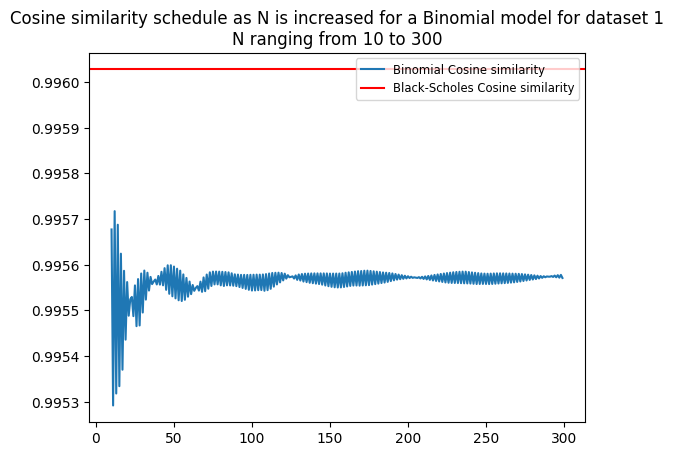

In [63]:
a1 = 10
a2 = 300
plt.plot(np.arange(a1, a2), CSim[a1:a2], label='Binomial Cosine similarity')
plt.title(f'Cosine similarity schedule as N is increased for a Binomial model for dataset 1\nN ranging from {a1} to {a2}')
plt.axhline(cosine_similarity(df1_result_bs['predicted_price'],df1_result_bs['actual_price']), label='Black-Scholes Cosine similarity', color = 'red')
plt.legend(loc='upper right', fontsize='small')
